C:\Users\yocan\AppData\Local\Temp\ipykernel_79516\2447309226.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  lagged_df['correlation'] = lagged_df.groupby(['site', 'season', 'lag']).apply(
c:\Users\yocan\anaconda3\Lib\site-packages\seaborn\axisgrid.py:186: UserWarning: Mismatched number of handles and labels: len(handles) = 0 len(labels) = 2
  figlegend = self._figure.legend(handles, labels, **kwargs)


<Figure size 1600x1200 with 0 Axes>

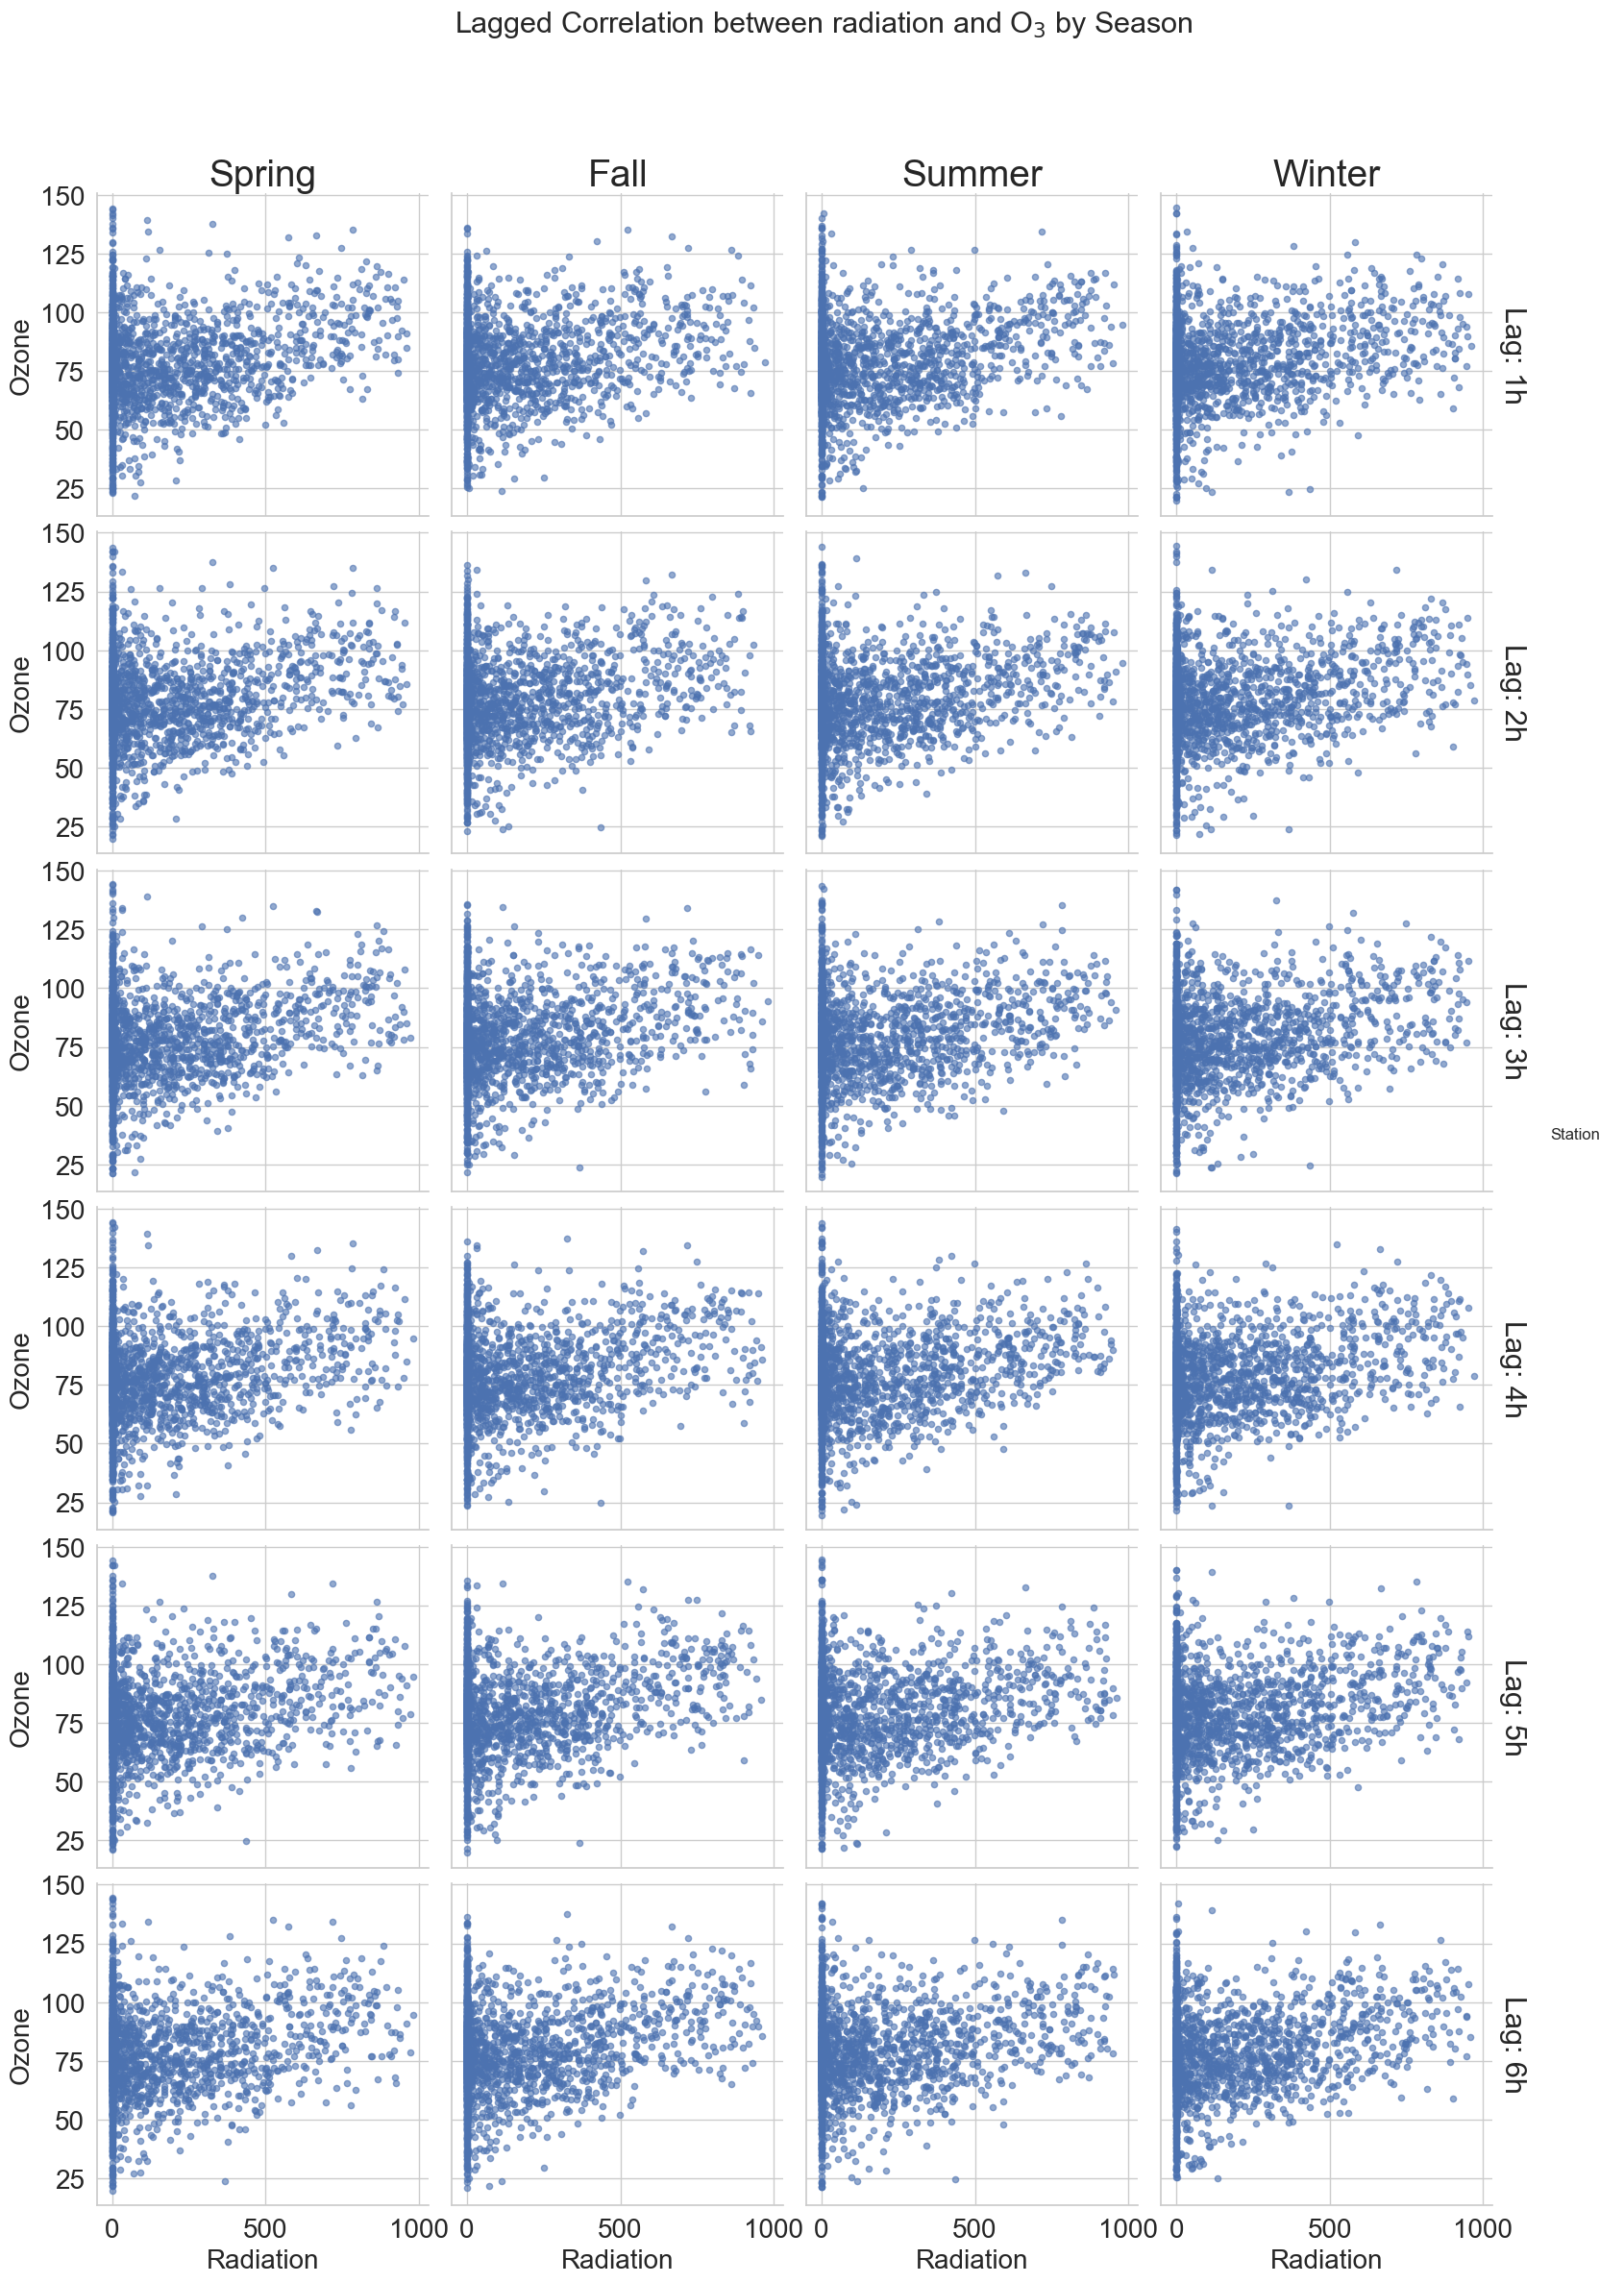

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# 1. Load the data
df = pd.read_csv('DATA.csv', sep=';', parse_dates=['TIME'], dayfirst=True)

# Clean data (e.g., replace commas with dots in decimal numbers and convert to float)
df.replace({',': '.'}, regex=True, inplace=True)

# Convert relevant columns to numeric
cols_to_convert = ['NO2MAG', 'NO2CHA', 'O3MAG', 'O3CHA', 'PM10MAG', 'PM10CHA',
                   'PRECMAG', 'PRECCHA', 'RADMAG', 'RADCHA', 'TEMPMAG', 'TEMPCHA',
                   'WINDDIRCHA', 'WINDDIRMAG', 'WINDSPECHA', 'WINDSPEMAG', 'PM2.5MAG', 'SO2MAG']
df[cols_to_convert] = df[cols_to_convert].apply(pd.to_numeric, errors='coerce')

# 2. Create a function to generate lagged pairs
def lagged_data(df, var1, var2, max_lag=6):
    lagged_list = []
    for lag in range(1, max_lag + 1):
        df_lagged = df.copy()
        df_lagged['lag'] = lag
        df_lagged[f'{var1}_lagged'] = df_lagged[var1].shift(lag)
        df_lagged[f'{var2}_lagged'] = df_lagged[var2].shift(lag)
        df_lagged = df_lagged.dropna(subset=[f'{var1}_lagged', f'{var2}_lagged'])
        lagged_list.append(df_lagged[['TIME', 'site', 'season', f'{var1}_lagged', f'{var2}_lagged', 'lag']])
    return pd.concat(lagged_list)

# 3. Add site and season columns (for demonstration purposes)
df['site'] = np.random.choice(['MAG', 'CHA'], size=len(df))
df['season'] = np.random.choice(['Winter', 'Spring', 'Summer', 'Fall'], size=len(df))

# 4. Create lagged pairs for RAD and O3
lagged_df = lagged_data(df, 'RADCHA', 'O3CHA')

# 5. Compute correlation for each lag
lagged_df['correlation'] = lagged_df.groupby(['site', 'season', 'lag']).apply(
    lambda group: group['RADCHA_lagged'].corr(group['O3CHA_lagged'])
).reset_index(level=[0,1,2], drop=True)

# 6. Plotting the results
plt.figure(figsize=(16, 12))  # Larger plot size for better readability
sns.set(style="whitegrid")

# Define color mapping (MAG: green, CHA: red)
color_map = {'MAG': 'green', 'CHA': 'red'}

# Create the FacetGrid for the scatter plot with smaller points and bigger legend text
g = sns.FacetGrid(lagged_df, col="season", row="lag", margin_titles=True, height=4, palette=color_map)

# Map the scatter plot on the grid
g.map(plt.scatter, 'RADCHA_lagged', 'O3CHA_lagged', alpha=0.6, s=20)

# Set axis labels
g.set_axis_labels('Radiation', 'Ozone')

# Set titles for the grid
g.set_titles(col_template="{col_name}", row_template="Lag: {row_name}h", size=22)

# Customize the plots and legends
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Lagged Correlation between radiation and O$_3$ by Season', fontsize=22)

# Increase font size for axis labels, ticks, and legend
for ax in g.axes.flatten():
    ax.set_xlabel(ax.get_xlabel(), fontsize=20)  # Increase x-axis label font size
    ax.set_ylabel(ax.get_ylabel(), fontsize=20)  # Increase y-axis label font size
    ax.tick_params(axis='both', labelsize=20)  # Increase tick label size

# Add legend with the correct labels and bigger text size
handles, labels = ax.get_legend_handles_labels()
g.add_legend(title='Station', handles=handles, labels=['CHA', 'MAG'], fontsize=20)

# Increase title text size for facet titles
for ax in g.axes.flatten():
    ax.title.set_fontsize(22)

# Show plot
plt.show()


